# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [424]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [425]:
df = pd.read_csv('/Users/ianweimer/1083-albumin-data-exploration/ML/tables/albumin_cleaned_8.csv')

In [426]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [427]:
df.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   1            2.0    6   
1    0                 0                   0            3.0    2   
2    0                 0                   0            0.0    2   
3    1                 0                   2            0.0    2   
4    0                 0                   0            2.0    3   

   bl_albumin_value  albumin_24hrs  5_percent_albumin  25_percent_albumin  \
0               2.9            0.0                0.0                 0.0   
1               1.5            0.0                0.0                 1.0   
2               3.9            1.0                1.0                 1.0   
3               2.8            0.0                0.0                 1.0   
4               1.5            0.0                0.0                 1.0   

   unknown_albumin_type  MELD  qSOFA  Cirrhosis  beta_blocker  hemorrhagic  \
0                   1.0  11.0      1          0             1            0   
1                   0.0   9.0      0          1             0            0   
2                   0.0  10.0      0          0             1            0   
3                   1.0   7.0      0          0             0            0   
4                   0.0  18.0      3          0             1            0   

   30_day_mortality  30_day_readmission  LOS_days  
0                 0                   0         2  
1                 0                   0         1  
2                 0                   0         2  
3                 1                   0         1  
4                 0                   0         2

In [428]:
df.shape

(31732, 18)

In [429]:
df.drop(columns=['30_day_readmission', '30_day_mortality'], inplace=True)

In [430]:
#df.drop(columns=['5_percent_albumin'], inplace=True)

In [431]:
df.describe()

ICU  mass_transfusion  total_transfusions  anemia_status  \
count  31732.000000      31732.000000        31732.000000   31732.000000   
mean       0.225009          0.031798            0.714515       1.645941   
std        0.417595          0.175464            1.120161       1.128295   
min        0.000000          0.000000            0.000000       0.000000   
25%        0.000000          0.000000            0.000000       0.000000   
50%        0.000000          0.000000            0.000000       2.000000   
75%        0.000000          0.000000            1.000000       3.000000   
max        1.000000          1.000000            6.000000       3.000000   

               CCI  bl_albumin_value  albumin_24hrs  5_percent_albumin  \
count  31732.00000      31732.000000   31732.000000       31732.000000   
mean       3.64030          3.109364       0.060601           0.059026   
std        2.69008          0.692700       0.238601           0.235676   
min        0.00000          0.002700       0.000000           0.000000   
25%        1.00000          2.600000       0.000000           0.000000   
50%        3.00000          3.100000       0.000000           0.000000   
75%        5.00000          3.600000       0.000000           0.000000   
max       19.00000          6.300000       1.000000           1.000000   

       25_percent_albumin  unknown_albumin_type          MELD         qSOFA  \
count        31732.000000          31732.000000  31732.000000  31732.000000   
mean             0.088901              0.097378     12.393195      0.478381   
std              0.284605              0.296477      6.832653      0.684935   
min              0.000000              0.000000      6.000000      0.000000   
25%              0.000000              0.000000      8.000000      0.000000   
50%              0.000000              0.000000     10.000000      0.000000   
75%              0.000000              0.000000     15.000000      1.000000   
max              1.000000              1.000000     40.000000      3.000000   

          Cirrhosis  beta_blocker   hemorrhagic      LOS_days  
count  31732.000000  31732.000000  31732.000000  31732.000000  
mean       0.236953      0.337199      0.068165      0.963507  
std        0.425220      0.472761      0.252032      0.826161  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      1.000000  
75%        0.000000      1.000000      0.000000      2.000000  
max        1.000000      1.000000      1.000000      2.000000

## Modeling

In [432]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [433]:
cols

Index(['ICU', 'mass_transfusion', 'total_transfusions', 'anemia_status', 'CCI',
       'bl_albumin_value', 'albumin_24hrs', '5_percent_albumin',
       '25_percent_albumin', 'unknown_albumin_type', 'MELD', 'qSOFA',
       'Cirrhosis', 'beta_blocker', 'hemorrhagic'],
      dtype='object')

## Standardize Data

In [434]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [435]:
X.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   1            2.0    6   
1    0                 0                   0            3.0    2   
2    0                 0                   0            0.0    2   
3    1                 0                   2            0.0    2   
4    0                 0                   0            2.0    3   

   bl_albumin_value  albumin_24hrs  5_percent_albumin  25_percent_albumin  \
0               2.9            0.0                0.0                 0.0   
1               1.5            0.0                0.0                 1.0   
2               3.9            1.0                1.0                 1.0   
3               2.8            0.0                0.0                 1.0   
4               1.5            0.0                0.0                 1.0   

   unknown_albumin_type  MELD  qSOFA  Cirrhosis  beta_blocker  hemorrhagic  
0                   1.0  11.0      1          0             1            0  
1                   0.0   9.0      0          1             0            0  
2                   0.0  10.0      0          0             1            0  
3                   1.0   7.0      0          0             0            0  
4                   0.0  18.0      3          0             1            0

## Train Test Split

In [436]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [437]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.22690
Feature: mass_transfusion Score: -0.17493
Feature: total_transfusions Score: -0.00182
Feature: anemia_status Score: 0.14966
Feature: CCI Score: -0.10169
Feature: bl_albumin_value Score: 0.25001
Feature: albumin_24hrs Score: 0.47312
Feature: 5_percent_albumin Score: -0.55929
Feature: 25_percent_albumin Score: -0.73785
Feature: unknown_albumin_type Score: -1.02297
Feature: MELD Score: -0.01840
Feature: qSOFA Score: -0.20017
Feature: Cirrhosis Score: 0.37964
Feature: beta_blocker Score: -0.28007
Feature: hemorrhagic Score: -0.31472


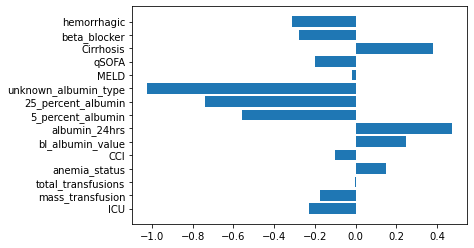

In [438]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                      Importance
albumin_24hrs           1.604991
Cirrhosis               1.461754
bl_albumin_value        1.284034
anemia_status           1.161437
total_transfusions      0.998181
MELD                    0.981767
CCI                     0.903312
mass_transfusion        0.839518
qSOFA                   0.818594
ICU                     0.797004
beta_blocker            0.755733
hemorrhagic             0.729991
5_percent_albumin       0.571613
25_percent_albumin      0.478141
unknown_albumin_type    0.359526


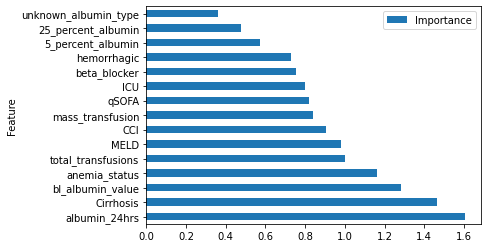

In [439]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [440]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [441]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[6718 1366 1024]
 [4272 1868 1877]
 [2100 1369 4791]]


In [442]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.51      0.74      0.61      9108
           1       0.41      0.23      0.30      8017
           2       0.62      0.58      0.60      8260

    accuracy                           0.53     25385
   macro avg       0.51      0.52      0.50     25385
weighted avg       0.51      0.53      0.51     25385



In [443]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1669  362  290]
 [1078  444  493]
 [ 509  359 1143]]


In [444]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.51      0.72      0.60      2321
           1       0.38      0.22      0.28      2015
           2       0.59      0.57      0.58      2011

    accuracy                           0.51      6347
   macro avg       0.50      0.50      0.49      6347
weighted avg       0.50      0.51      0.49      6347



## 1: Decision Tree (Max Depth=3)

In [445]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.00000
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.01525
Feature: CCI Score: 0.17779
Feature: bl_albumin_value Score: 0.00000
Feature: albumin_24hrs Score: 0.07412
Feature: 5_percent_albumin Score: 0.00000
Feature: 25_percent_albumin Score: 0.22225
Feature: unknown_albumin_type Score: 0.51060
Feature: MELD Score: 0.00000
Feature: qSOFA Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000


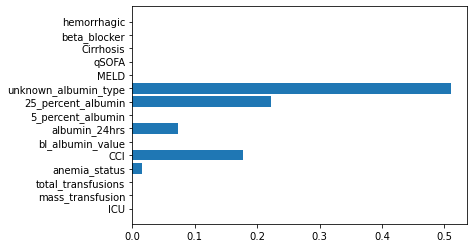

In [446]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [447]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [448]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[8782    0  326]
 [7268    0  749]
 [5459    0 2801]]


In [449]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.41      0.96      0.57      9108
           1       0.00      0.00      0.00      8017
           2       0.72      0.34      0.46      8260

    accuracy                           0.46     25385
   macro avg       0.38      0.43      0.35     25385
weighted avg       0.38      0.46      0.36     25385



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [450]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[2238    0   83]
 [1837    0  178]
 [1317    0  694]]


In [451]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.96      0.58      2321
           1       0.00      0.00      0.00      2015
           2       0.73      0.35      0.47      2011

    accuracy                           0.46      6347
   macro avg       0.38      0.44      0.35      6347
weighted avg       0.38      0.46      0.36      6347



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


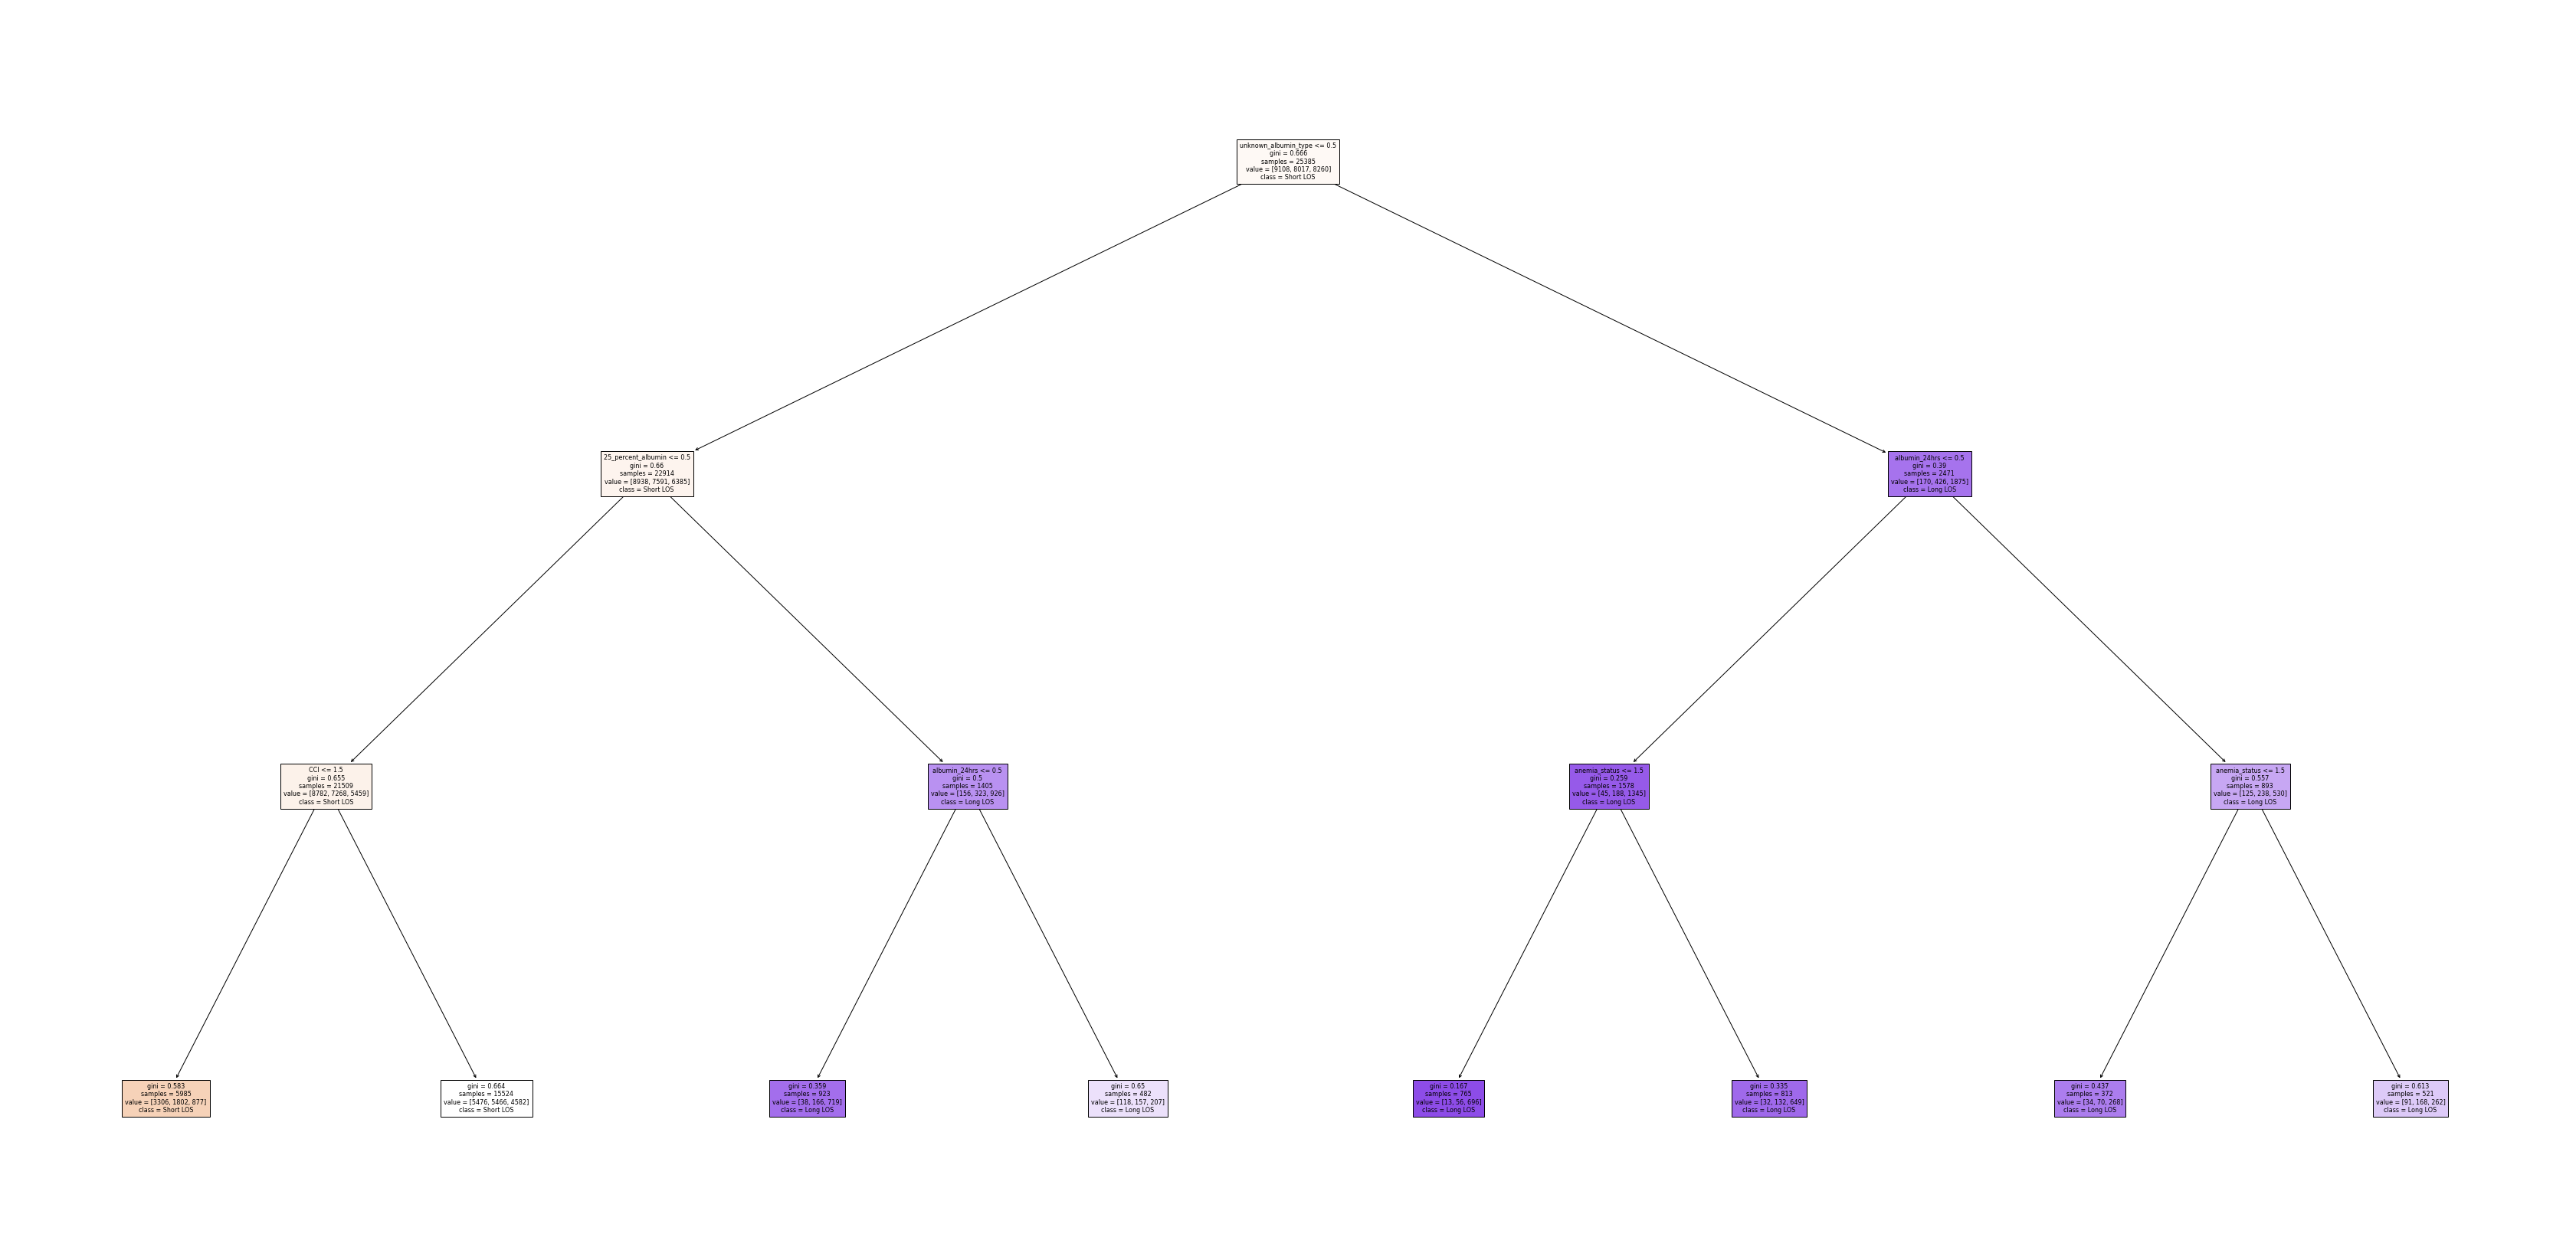

In [452]:
feature_names = df.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

## 2: Decision Tree (Max Depth=4)

In [453]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.00239
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.01921
Feature: CCI Score: 0.21930
Feature: bl_albumin_value Score: 0.02541
Feature: albumin_24hrs Score: 0.06587
Feature: 5_percent_albumin Score: 0.01151
Feature: 25_percent_albumin Score: 0.20253
Feature: unknown_albumin_type Score: 0.45378
Feature: MELD Score: 0.00000
Feature: qSOFA Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000


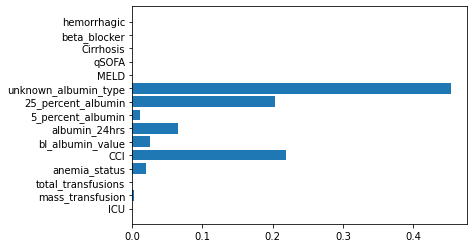

In [454]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [455]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [456]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[7000  102 2006]
 [5005  141 2871]
 [3143  132 4985]]


In [457]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.46      0.77      0.58      9108
           1       0.38      0.02      0.03      8017
           2       0.51      0.60      0.55      8260

    accuracy                           0.48     25385
   macro avg       0.45      0.46      0.39     25385
weighted avg       0.45      0.48      0.40     25385



In [458]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1773   26  522]
 [1243   27  745]
 [ 759   43 1209]]


In [459]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.47      0.76      0.58      2321
           1       0.28      0.01      0.03      2015
           2       0.49      0.60      0.54      2011

    accuracy                           0.47      6347
   macro avg       0.41      0.46      0.38      6347
weighted avg       0.42      0.47      0.39      6347



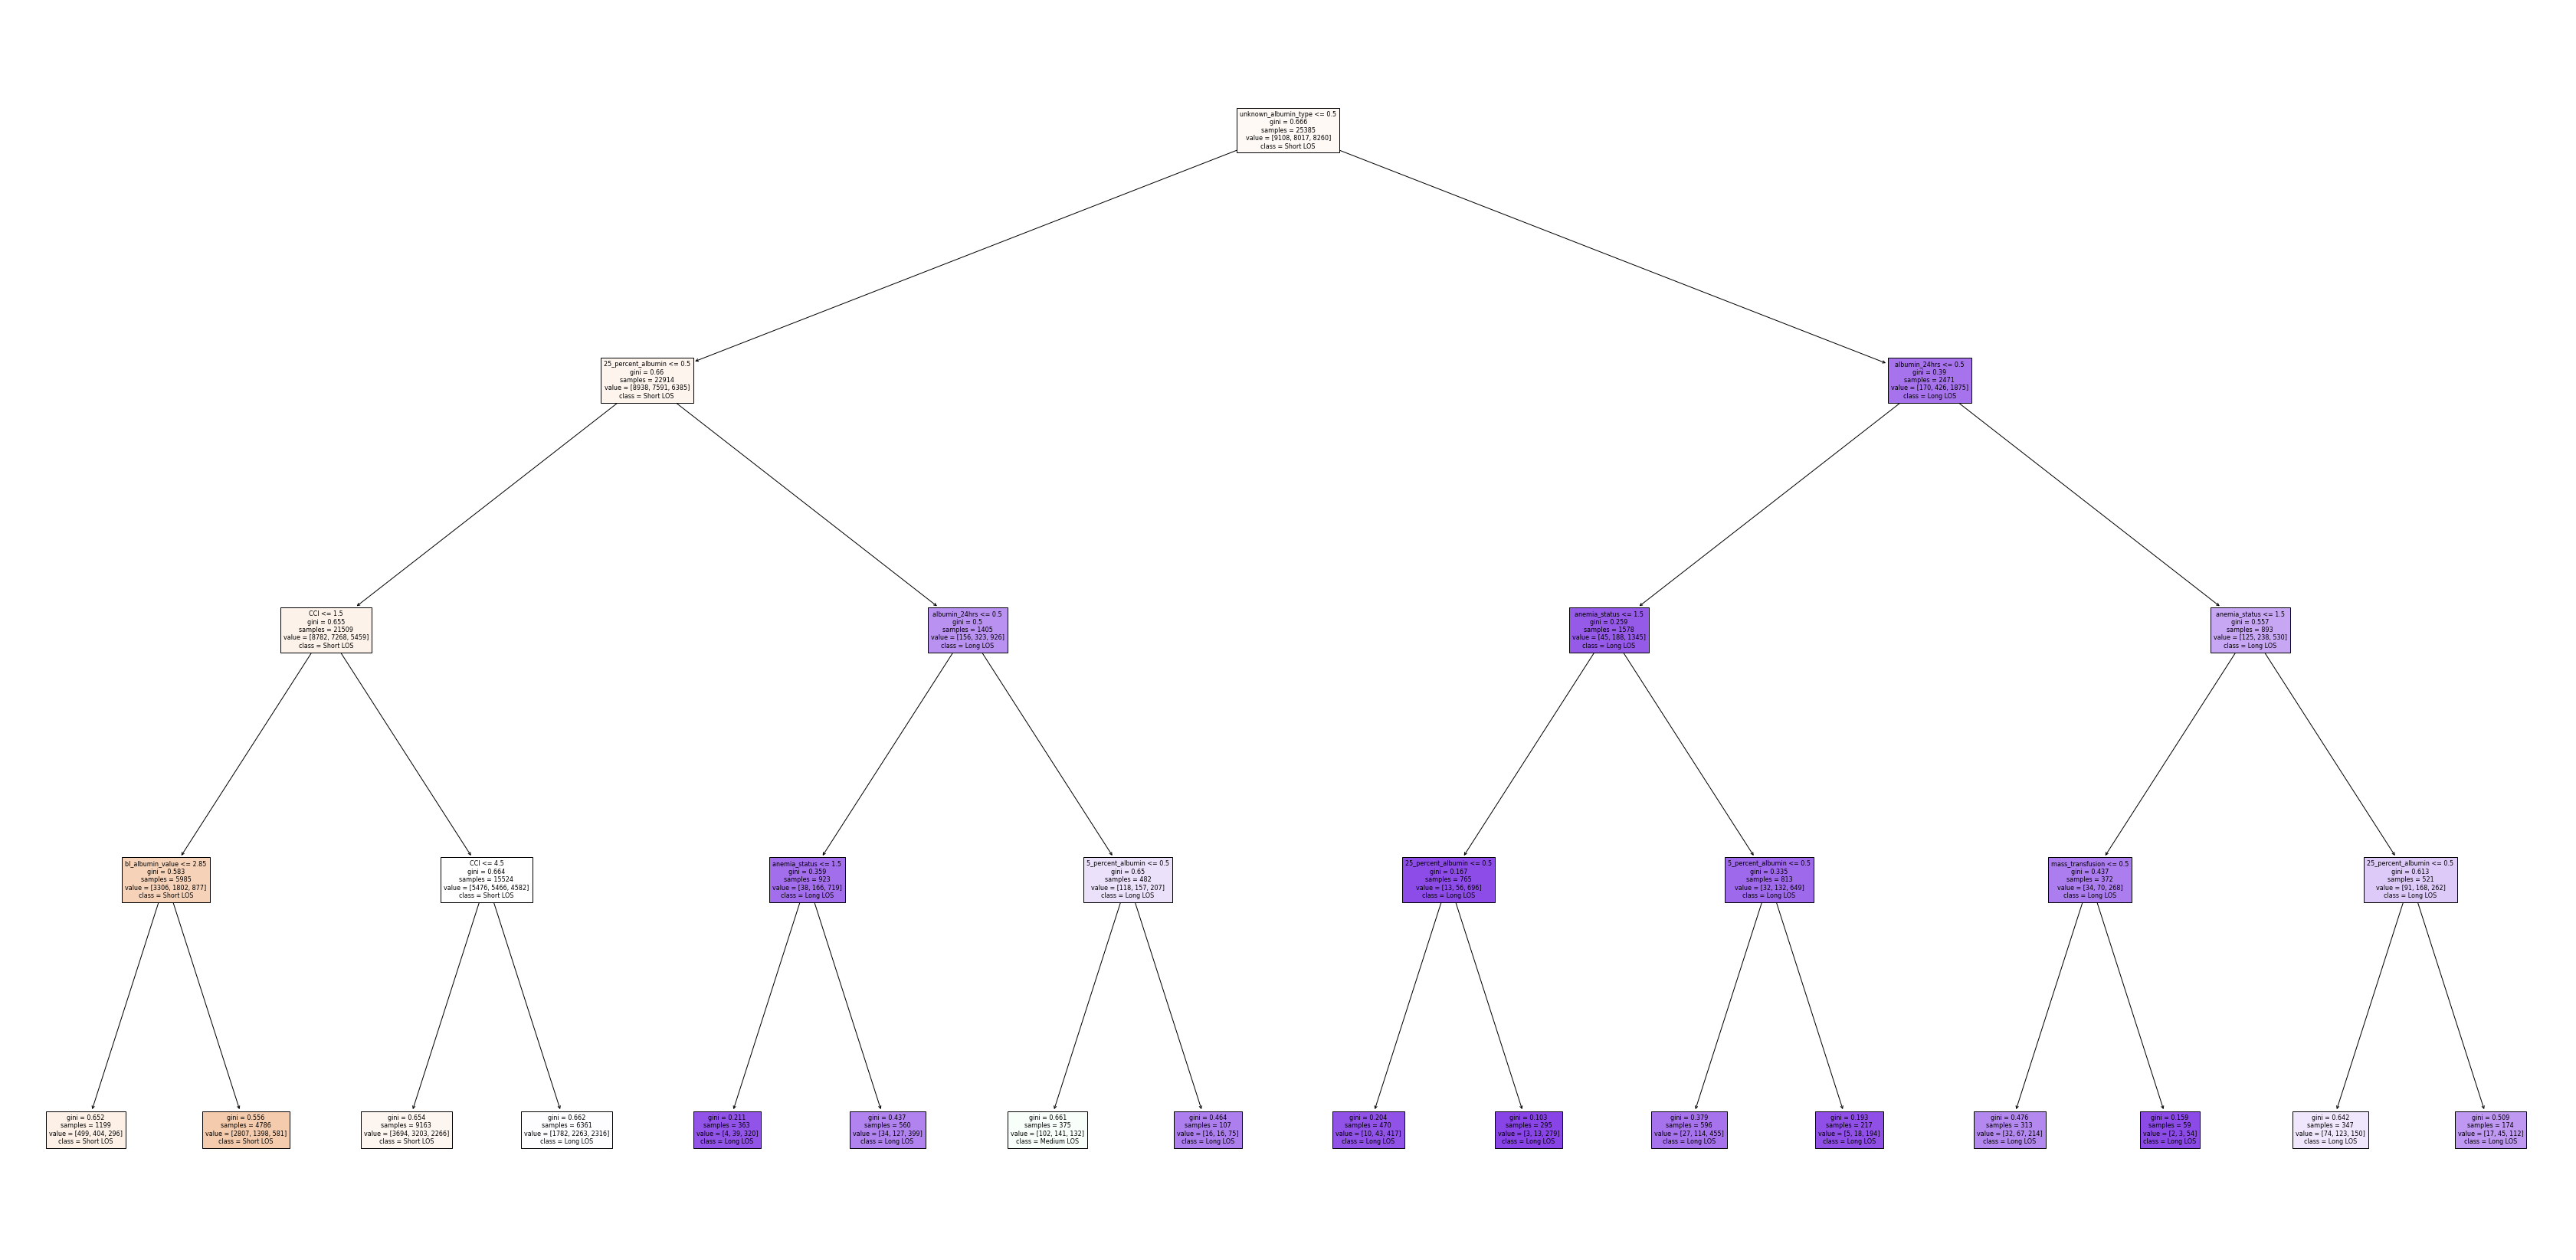

In [460]:
feature_names = df.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

## 3: Decision Tree 

In [461]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=5, \
                                 min_samples_leaf=5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.00215
Feature: total_transfusions Score: 0.00180
Feature: anemia_status Score: 0.04542
Feature: CCI Score: 0.20074
Feature: bl_albumin_value Score: 0.03091
Feature: albumin_24hrs Score: 0.05932
Feature: 5_percent_albumin Score: 0.01372
Feature: 25_percent_albumin Score: 0.18264
Feature: unknown_albumin_type Score: 0.40868
Feature: MELD Score: 0.00000
Feature: qSOFA Score: 0.04800
Feature: Cirrhosis Score: 0.00662
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000


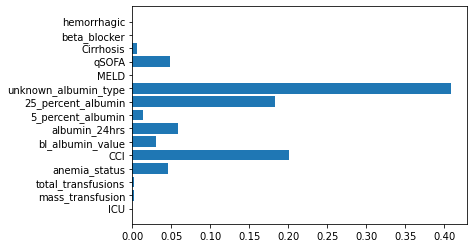

In [462]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [463]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [464]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[5850 2670  588]
 [3720 3190 1107]
 [1947 2794 3519]]


In [465]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.51      0.64      0.57      9108
           1       0.37      0.40      0.38      8017
           2       0.67      0.43      0.52      8260

    accuracy                           0.49     25385
   macro avg       0.52      0.49      0.49     25385
weighted avg       0.52      0.49      0.49     25385



In [466]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1459  685  177]
 [ 909  818  288]
 [ 477  690  844]]


In [467]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.51      0.63      0.56      2321
           1       0.37      0.41      0.39      2015
           2       0.64      0.42      0.51      2011

    accuracy                           0.49      6347
   macro avg       0.51      0.48      0.49      6347
weighted avg       0.51      0.49      0.49      6347



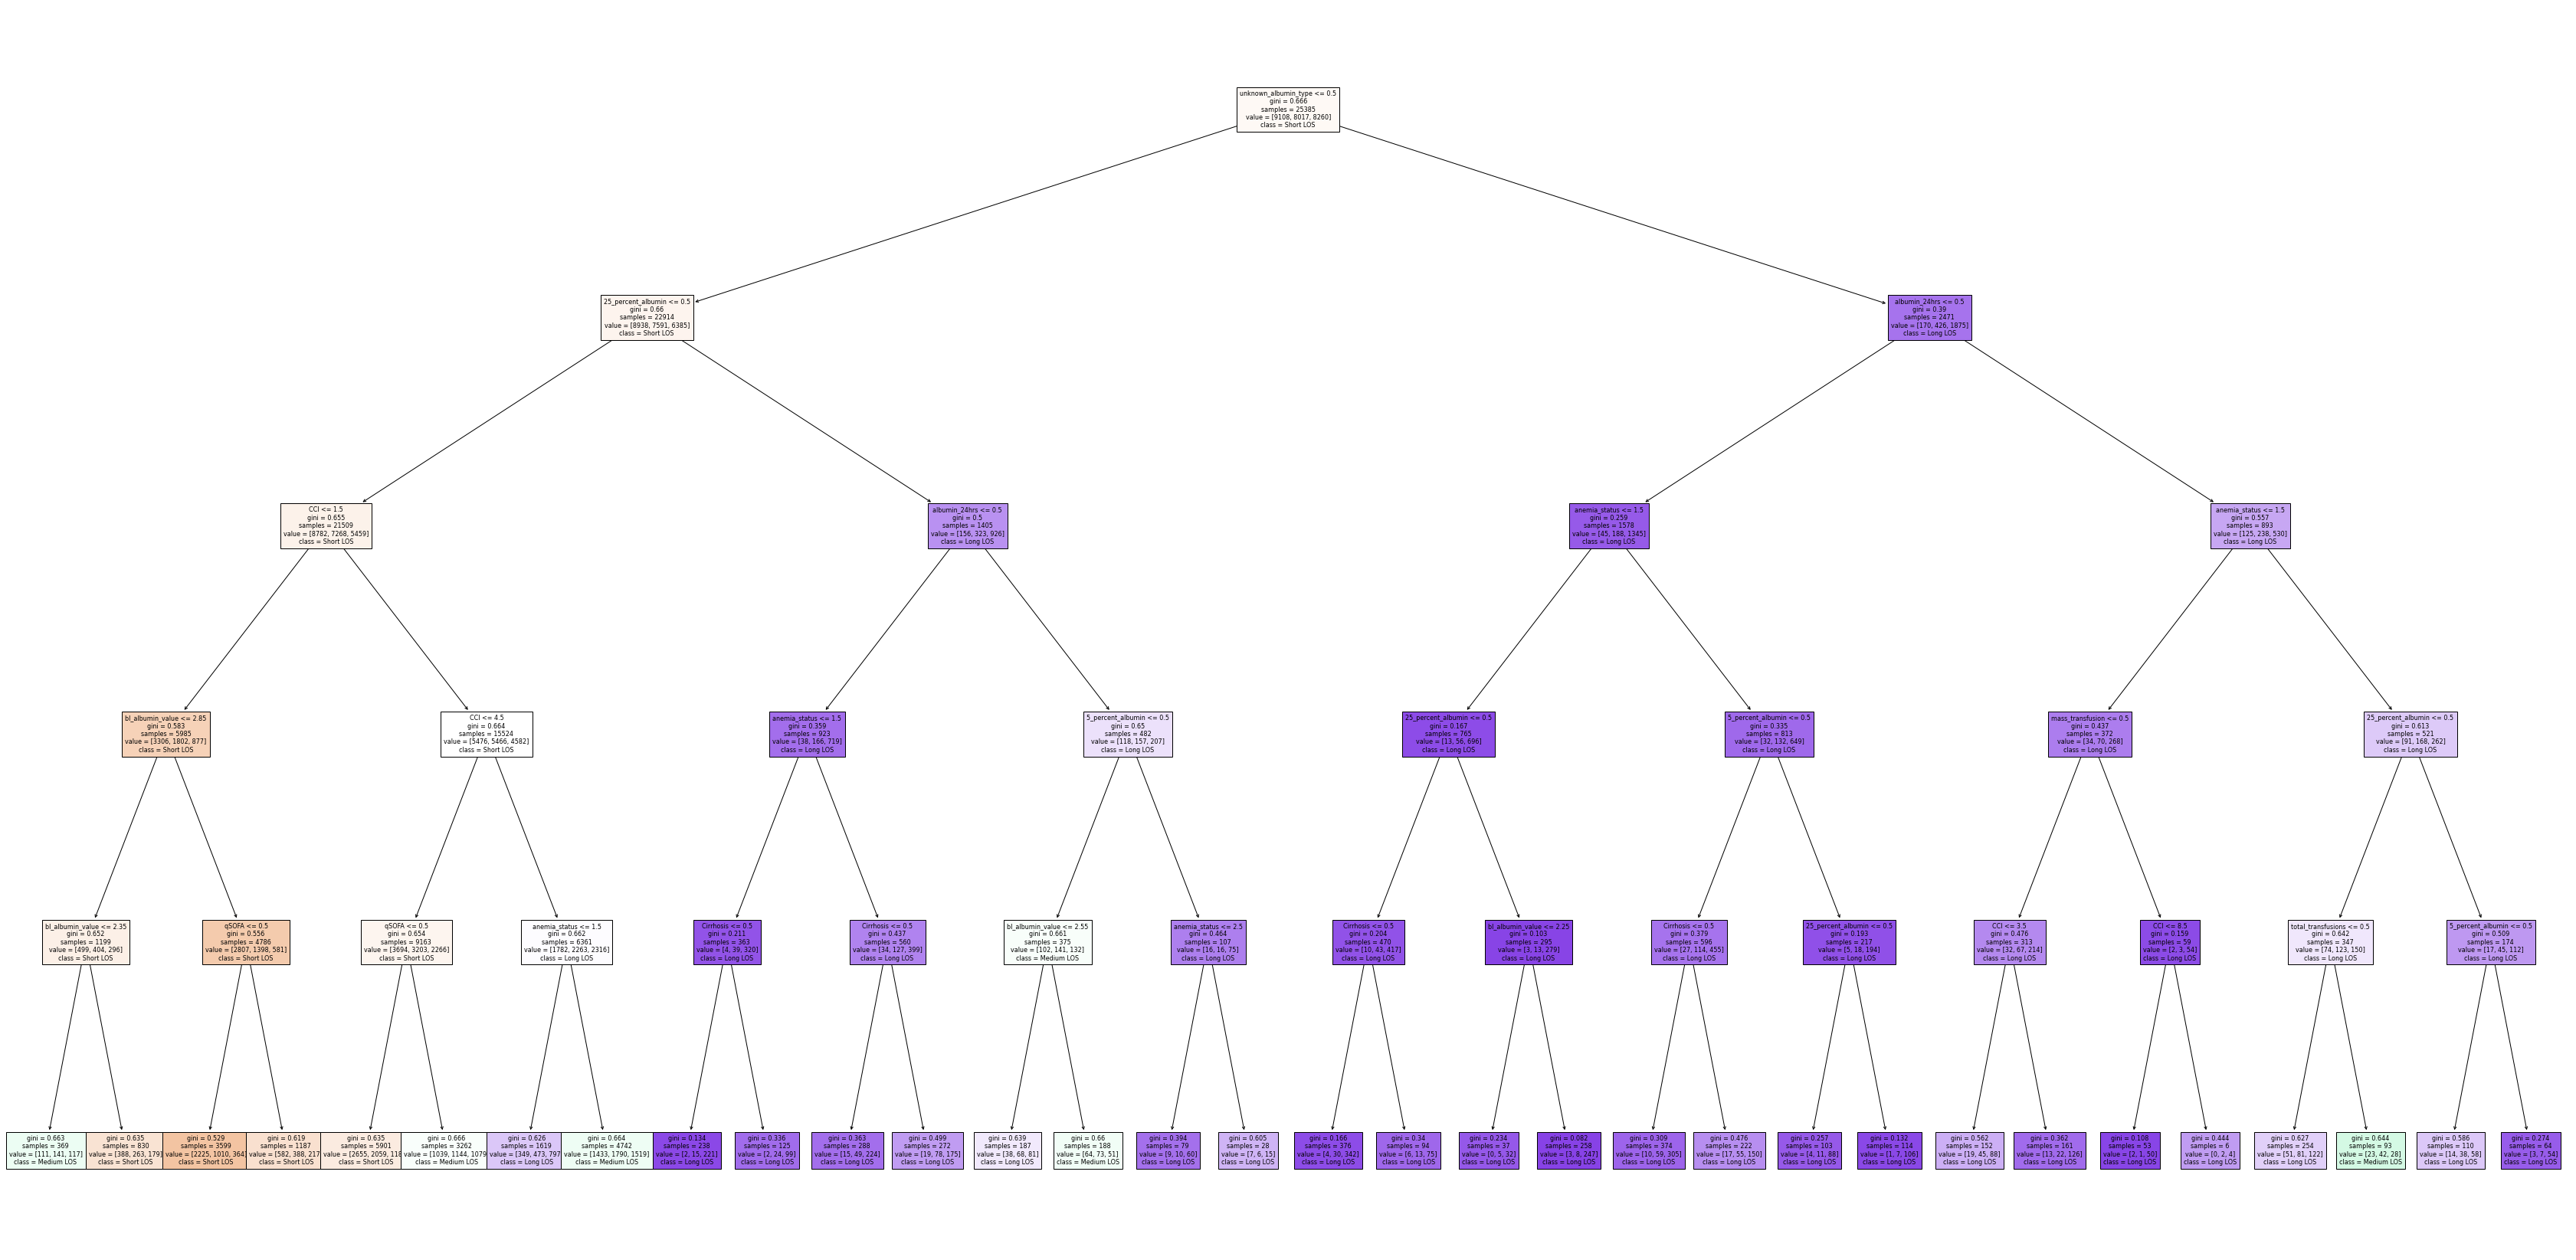

In [468]:
feature_names = df.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

## 4: Decision Tree 

In [315]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=4, min_samples_split=5, \
                                 min_samples_leaf=50)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=5)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.00239
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.01921
Feature: CCI Score: 0.21930
Feature: bl_albumin_value Score: 0.02541
Feature: albumin_24hrs Score: 0.06587
Feature: 5_percent_albumin Score: 0.01151
Feature: 25_percent_albumin Score: 0.20253
Feature: unknown_albumin_type Score: 0.45378
Feature: MELD Score: 0.00000
Feature: qSOFA Score: 0.00000
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000


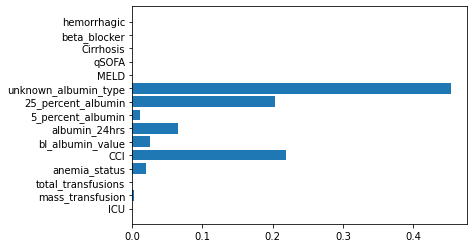

In [316]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [317]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [318]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[7000  102 2006]
 [5005  141 2871]
 [3143  132 4985]]


In [319]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.46      0.77      0.58      9108
           1       0.38      0.02      0.03      8017
           2       0.51      0.60      0.55      8260

    accuracy                           0.48     25385
   macro avg       0.45      0.46      0.39     25385
weighted avg       0.45      0.48      0.40     25385



In [320]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1773   26  522]
 [1243   27  745]
 [ 759   43 1209]]


In [321]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.47      0.76      0.58      2321
           1       0.28      0.01      0.03      2015
           2       0.49      0.60      0.54      2011

    accuracy                           0.47      6347
   macro avg       0.41      0.46      0.38      6347
weighted avg       0.42      0.47      0.39      6347



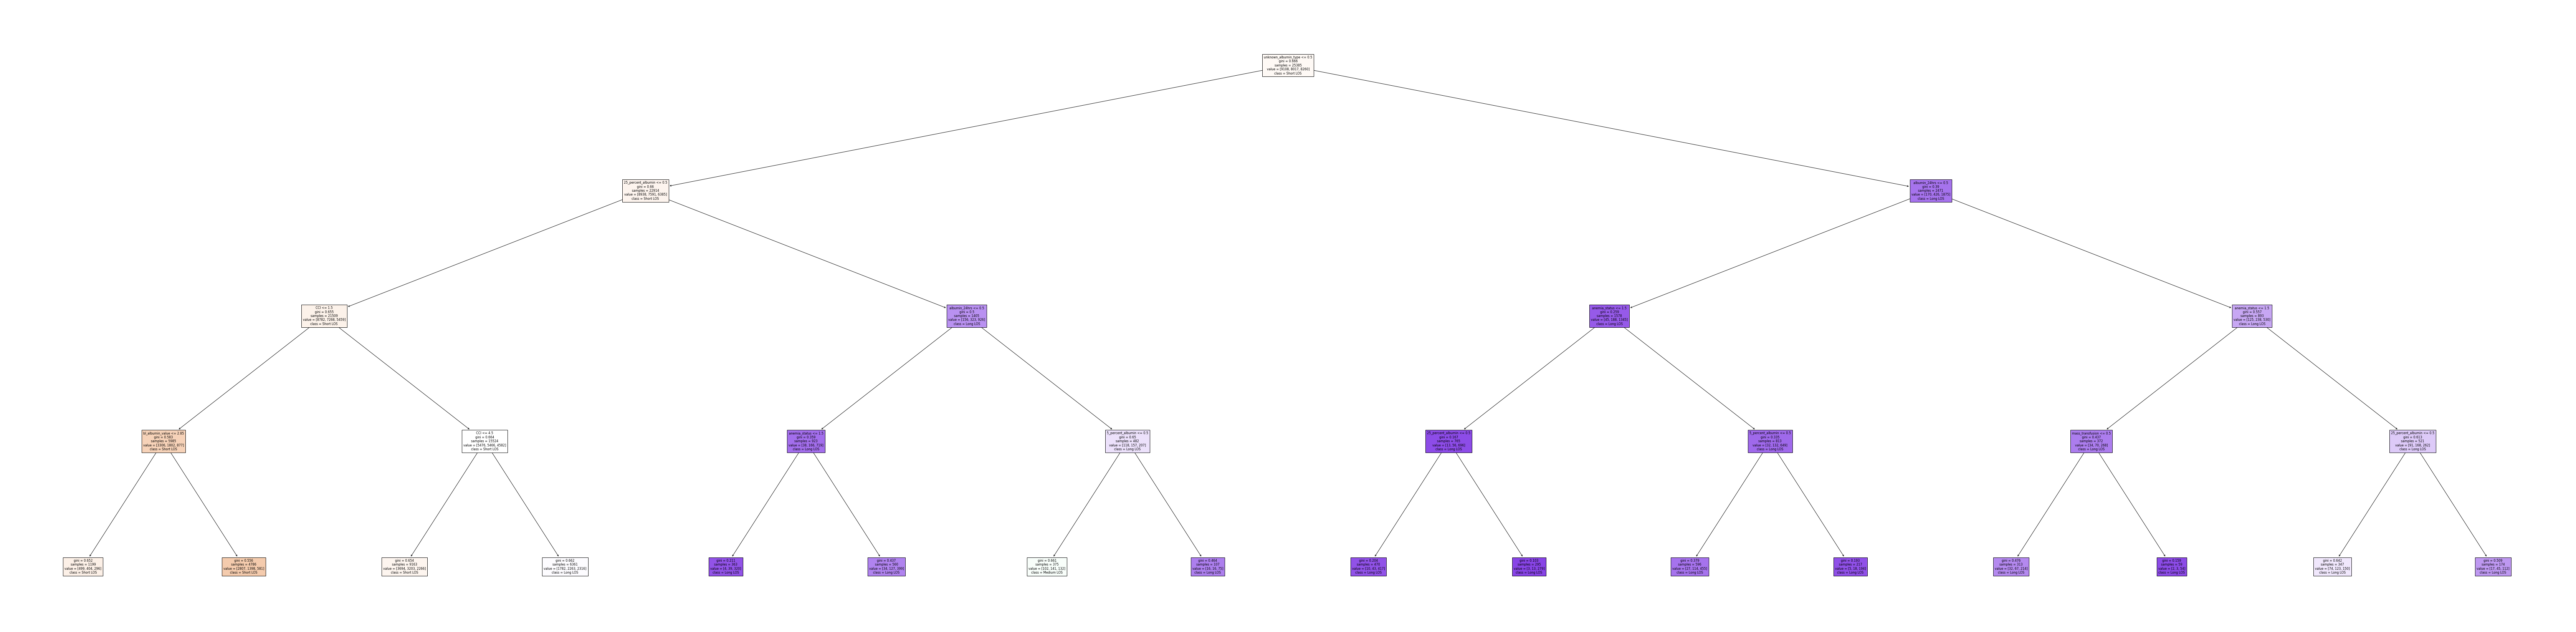

In [322]:
feature_names = df.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(120,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

## Optimized Model Using Grid Search

In [214]:
# instantiate a decision tree model
dt = tree.DecisionTreeClassifier()
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [215]:
# use grid search to select best parameters
# optimizing for accuracy

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

grid_cv = GridSearchCV(dt, param_grid, scoring="accuracy", n_jobs=-1, cv=3).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)

Param for GS {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}
CV score for GS 0.4950561836065474


In [216]:
# instantiate a decision tree model
dt = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf= 5, min_samples_split= 5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5)

Feature: ICU Score: 0.02292
Feature: mass_transfusion Score: 0.00273
Feature: total_transfusions Score: 0.02335
Feature: anemia_status Score: 0.06315
Feature: CCI Score: 0.15653
Feature: bl_albumin_value Score: 0.08743
Feature: albumin_24hrs Score: 0.03878
Feature: 5_percent_albumin Score: 0.02690
Feature: 25_percent_albumin Score: 0.11518
Feature: unknown_albumin_type Score: 0.25370
Feature: MELD Score: 0.07490
Feature: qSOFA Score: 0.05232
Feature: Cirrhosis Score: 0.03729
Feature: beta_blocker Score: 0.03515
Feature: hemorrhagic Score: 0.00967


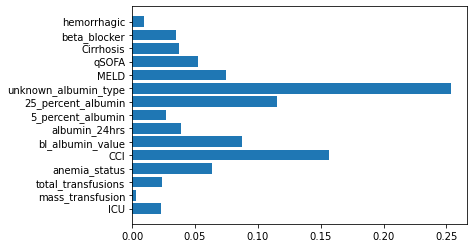

In [217]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [218]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [219]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[6805 1479  824]
 [4122 2572 1323]
 [2140 1518 4602]]


In [220]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.52      0.75      0.61      9108
           1       0.46      0.32      0.38      8017
           2       0.68      0.56      0.61      8260

    accuracy                           0.55     25385
   macro avg       0.55      0.54      0.54     25385
weighted avg       0.55      0.55      0.54     25385



In [221]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1636  424  261]
 [1037  541  437]
 [ 582  453  976]]


In [222]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.50      0.70      0.59      2321
           1       0.38      0.27      0.32      2015
           2       0.58      0.49      0.53      2011

    accuracy                           0.50      6347
   macro avg       0.49      0.49      0.48      6347
weighted avg       0.49      0.50      0.48      6347



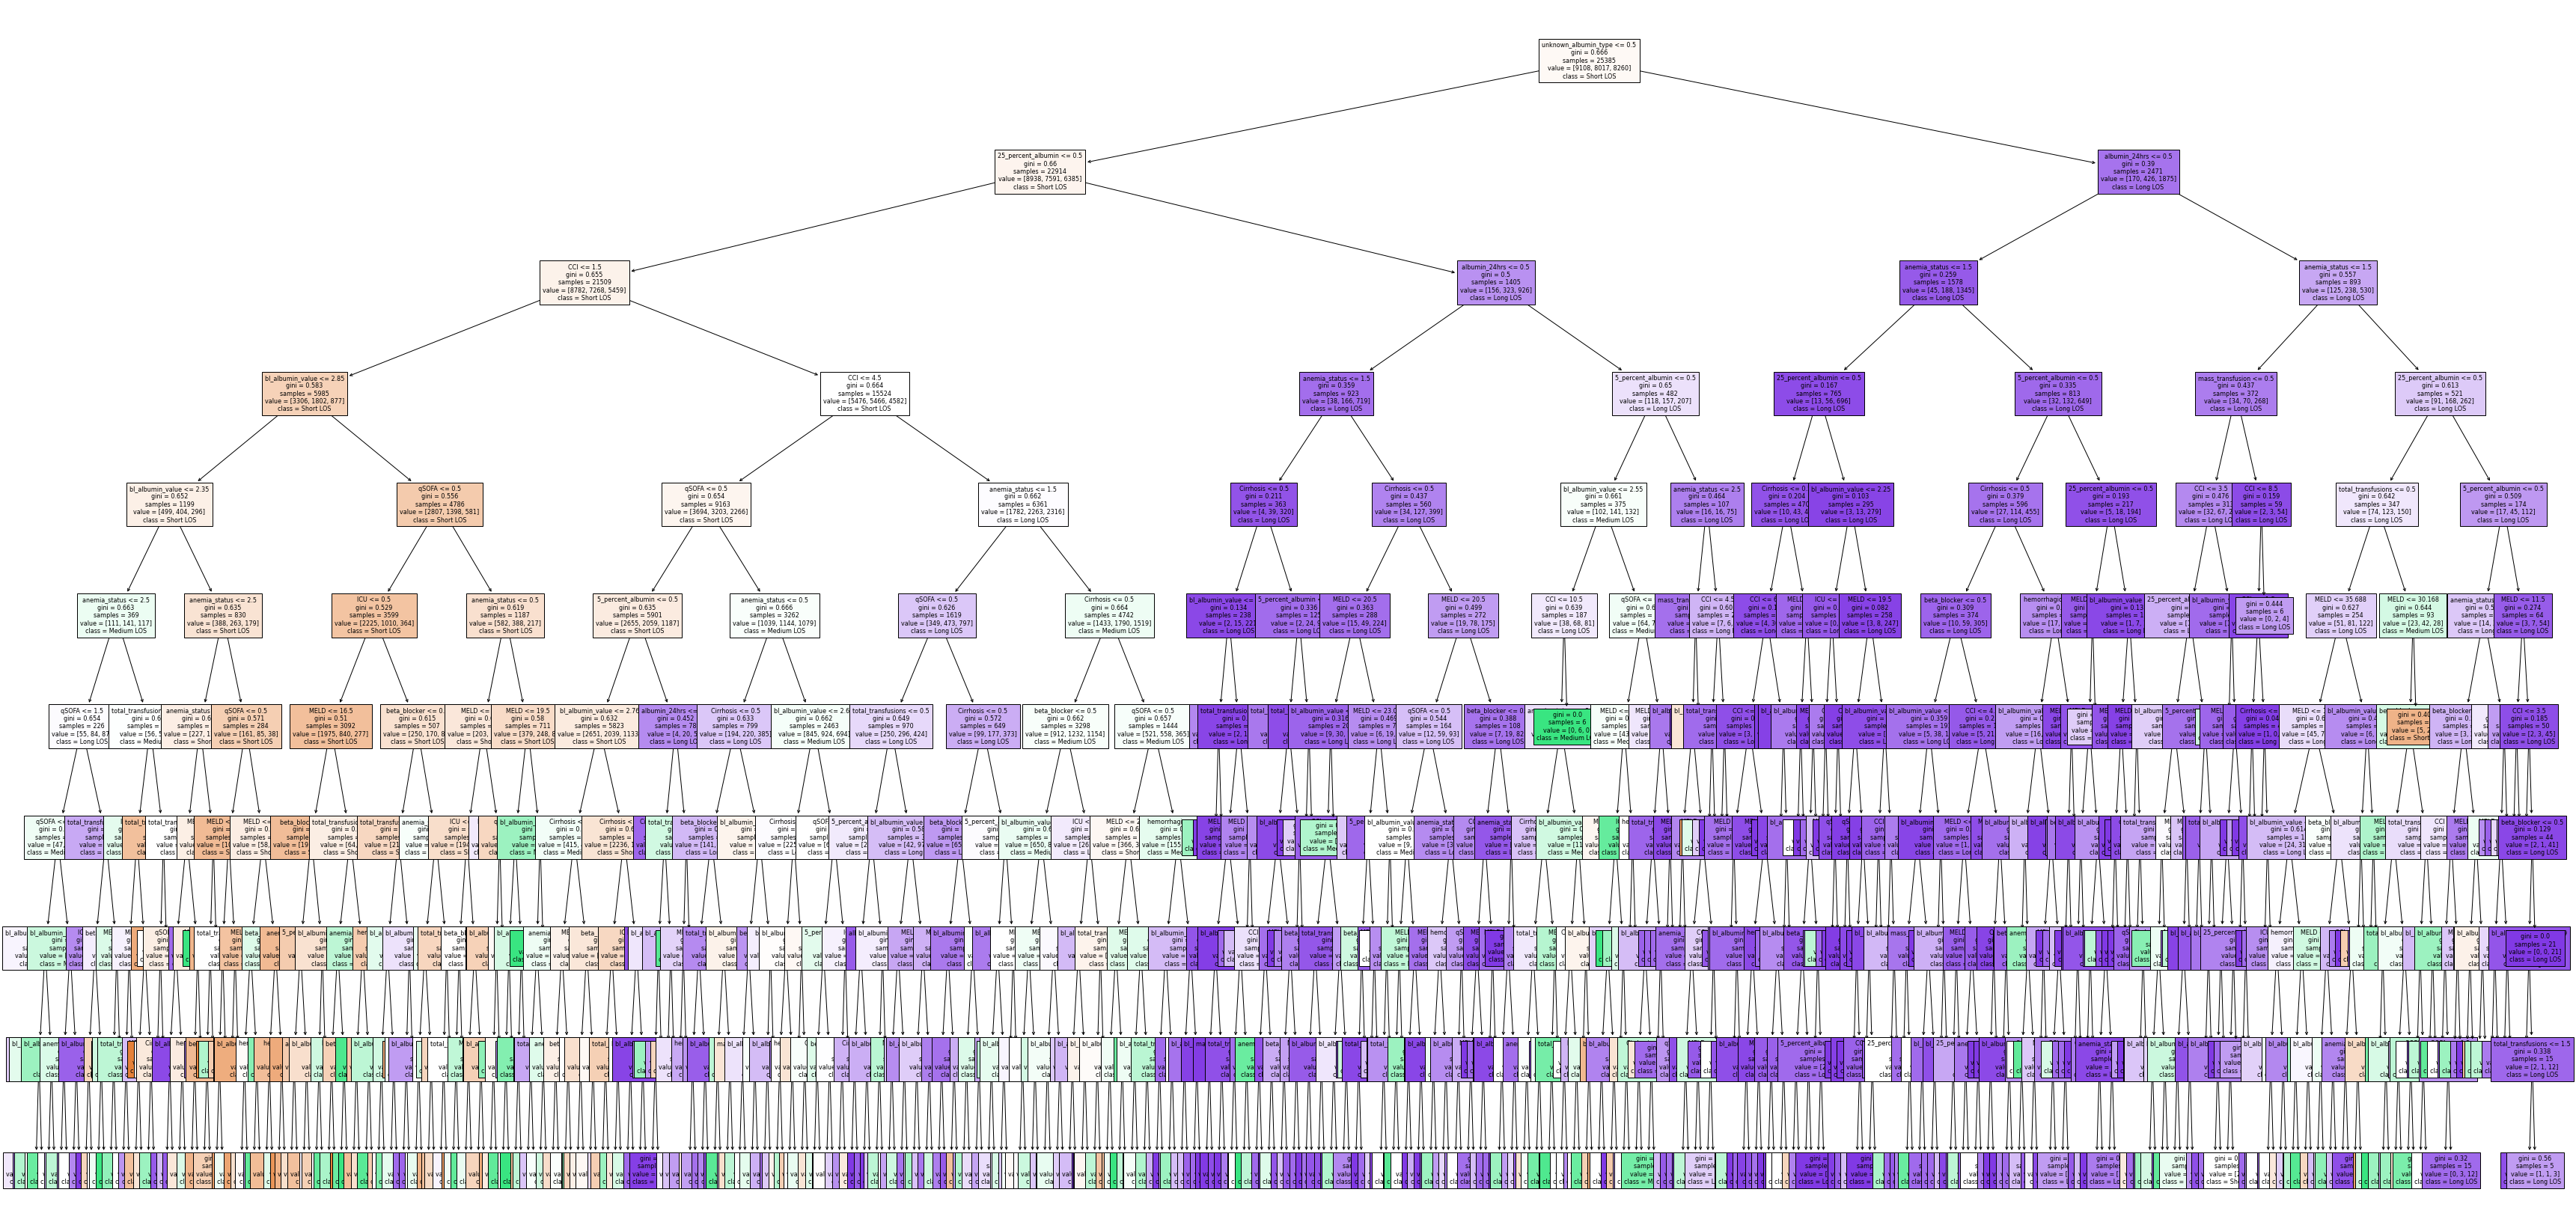

In [223]:
feature_names = df.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)